# Flights in the United States
## by Benoît Courty

## Preliminary Wrangling

This dataset reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays, from 1987 to 2008.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def pv(variable):
    if(len(variable)>1): print(variable, ":", eval(variable))

In [2]:
# import some packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Downloading the datasets

The dataset consist of a file per year.

We will look over a list of availiable years and download the files.

Source : 
http://stat-computing.org/dataexpo/2009/1987.csv.bz2

In [8]:
import os
import requests
folder_name = "./"


def download_files(folder_name, years):
    # Loop on years list
    for year in years:
        file_already_downloaded = False
        url = "http://stat-computing.org/dataexpo/2009/" + str(year) + ".csv.bz2"
        filename = url.split('/')[-1]
        # Check if he file has already been downloaded (exist on the disk)
        for files in os.listdir():
            if filename in files:
                print('The file', filename, 'has already been downloaded.');
                file_already_downloaded = True
                break
        # Download it if not present
        if not file_already_downloaded:
            response = requests.get(url)
            with open(os.path.join(folder_name, filename), mode='wb') as file:
                file.write(response.content)
            print('The file', filename, 'has been downloaded.');

#years = range(1987, 2008+1)
years = range(2008, 2008+1)
download_files(folder_name, years)

The file 2008.csv.bz2 has already been downloaded.


Now, we have our dataset, let's load it.

### Loading the dataset

I've writen the code to merge all the data, but it's too big for my computer.
If needed later I could sample data, or compute some agregate.

I will begin by using only 2008 as it is the more recent datas.

In [9]:
import pandas as pd

df = pd.DataFrame()
for year in years:
    datafilename = folder_name + str(year) + '.csv.bz2'
    print(datafilename)
    df_temp = pd.read_csv(datafilename)
    df = pd.concat([df, df_temp])

./2008.csv.bz2


Get a rapid overview of it.

In [10]:
# df.head(3)
# df.tail(3)
# df.columns
#df.dtypes
# df.describe()
# df.info()

It's a huge Dataset : 7 009 728 entries with 29 columns.

At first look it seems clean and tidy.

I have to change the type of FlightNum to String.

In [11]:
df = df.astype({"FlightNum": str})

Let's explore categorical variable with less than 15 unique values.

In [12]:
# Method that loop over each columns and display value_counts if there is less than 15 categorical values
def explore_value(df):
    to_be_removed = []
    columns = df.columns
    # Loop over columns
    for column in columns:
        nb_unique_values = eval('df.' + column + '.nunique()')
        #print("Distinct values in", column, ":", nb_unique_values)
        if nb_unique_values > 15:
            to_be_removed.append(column)
    columns_redux = [item for item in columns if item not in to_be_removed ]
    #print(columns_redux)
    # Loop over selection and display value_counts
    for column in columns_redux:
        code = 'df.' + column + '.value_counts()'
        print("Distinct values in", column, ':', code)
        print(eval(code))

explore_value(df)

Distinct values in Year : df.Year.value_counts()
2008    7009728
Name: Year, dtype: int64
Distinct values in Month : df.Month.value_counts()
7     627931
3     616090
8     612279
6     608665
5     606293
1     605765
4     598126
2     569236
10    556205
12    544958
9     540908
11    523272
Name: Month, dtype: int64
Distinct values in DayOfWeek : df.DayOfWeek.value_counts()
3    1039665
1    1036201
5    1035166
4    1032224
2    1032049
7     976887
6     857536
Name: DayOfWeek, dtype: int64
Distinct values in Cancelled : df.Cancelled.value_counts()
0    6872294
1     137434
Name: Cancelled, dtype: int64
Distinct values in CancellationCode : df.CancellationCode.value_counts()
B    54904
A    54330
C    28188
D       12
Name: CancellationCode, dtype: int64
Distinct values in Diverted : df.Diverted.value_counts()
0    6992463
1      17265
Name: Diverted, dtype: int64


Only 12 Security cancellation (D) in one year. We will have miss it if we have used a sample.

Check if it will be a good idea to merge CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay.

In [13]:
df.query("CarrierDelay > 0 and WeatherDelay > 0")[['CarrierDelay', 'WeatherDelay']][:3]

,CarrierDelay,WeatherDelay
98551,12.0,8.0
101614,224.0,120.0
303687,2.0,61.0


The delay could exist for more than one category, so we will not merge them.

## Dropping unnessary columns

I will drop some columns as I think I will not need them.

In [14]:
# Drop unused columns
df.drop(['Year', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime'], axis=1, inplace=True)

## Adding external data

We saw that the dataset contain only codes for airports and carriers, as we will display it, we are going to retreive the label for them.

I get it from  http://stat-computing.org/dataexpo/2009/supplemental-data.html :
- For City / Airport : http://stat-computing.org/dataexpo/2009/airports.csv
- For Carrier : http://stat-computing.org/dataexpo/2009/carriers.csv


In [15]:
def download(url):
    filename = url.split('/')[-1]
    response = requests.get(url)
    with open(os.path.join(folder_name, filename), mode='wb') as file:
        file.write(response.content)
    return filename
# download("http://stat-computing.org/dataexpo/2009/airports.csv")
# download("http://stat-computing.org/dataexpo/2009/carriers.csv")

In [16]:
df_airports = pd.read_csv("airports.csv")
df_carriers = pd.read_csv("carriers.csv")

Now we have the data, let's merge it with our dataset.

In [17]:
# Add Origin City name
df_tmp = df.merge(df_airports[['iata', 'city', 'state', 'lat', 'long']], how='left', left_on='Origin', right_on='iata')
df_tmp.drop('iata', axis=1, inplace=True)
df_tmp.rename(columns={'city':'OriginCity', 'state':'OriginState', 'lat':'OriginLat', 'long':'OriginLong'}, inplace=True)

# Add Destination City name
df_tmp = df_tmp.merge(df_airports[['iata', 'city', 'state', 'lat', 'long']], how='left', left_on='Dest', right_on='iata')
df_tmp.drop('iata', axis=1, inplace=True)
df_tmp.rename(columns={'city':'DestCity', 'state':'DestState', 'lat':'DestLat', 'long':'DestLong'}, inplace=True)

# Add Carrier Name
df_tmp = df_tmp.merge(df_carriers[['Code', 'Description']], how='left', left_on='UniqueCarrier', right_on='Code')
df_tmp.drop('Code', axis=1, inplace=True)
df_tmp.rename(columns={'Description':'CarrierName'}, inplace=True)

We still have a problem with state code instead of state name, let's improve it :

In [18]:
#filename = download("https://github.com/jasonong/List-of-US-States/raw/master/states.csv")
filename = "states.csv"
df_states = pd.read_csv(filename)

df_tmp = df_tmp.merge(df_states, how='left', left_on='OriginState', right_on='Abbreviation')
df_tmp.drop('Abbreviation', axis=1, inplace=True)
df_tmp.rename(columns={'State':'OriginStateName'}, inplace=True)


df_tmp = df_tmp.merge(df_states, how='left', left_on='DestState', right_on='Abbreviation')
df_tmp.drop('Abbreviation', axis=1, inplace=True)
df_tmp.rename(columns={'State':'DestStateName'}, inplace=True)


Check the data :

In [19]:
df_tmp[['OriginCity',
       'OriginState', 'OriginLat', 'OriginLong', 'DestCity', 'DestState',
       'DestLat', 'DestLong', 'CarrierName', 'OriginStateName',
       'DestStateName']].head(3)

,OriginCity,OriginState,OriginLat,OriginLong,DestCity,DestState,DestLat,DestLong,CarrierName,OriginStateName,DestStateName
0,Chantilly,VA,38.944532,-77.455810,Tampa,FL,27.975472,-82.533250,Southwest Airlines Co.,Virginia,Florida
1,Chantilly,VA,38.944532,-77.455810,Tampa,FL,27.975472,-82.533250,Southwest Airlines Co.,Virginia,Florida
2,Indianapolis,IN,39.717329,-86.294384,Baltimore,MD,39.175402,-76.668198,Southwest Airlines Co.,Indiana,Maryland


Great, we know have label better to understand, so let's replace main dataframe with our new one.

In [20]:
df = df_tmp;

We also have to rename a carrier that is too long :

In [21]:
df.CarrierName.replace('US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)', 'US Airways', inplace=True);

### What is the structure of your dataset?

As stated on http://stat-computing.org/dataexpo/2009/ :
The data consists of flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008. This is a large dataset: there are nearly 120 million records in total, and takes up 1.6 gigabytes of space compressed and 12 gigabytes when uncompressed. 

The data come from the US Bureau of Transportation Statistics.

The dataset is a series of CSV containing one line per flight in the US. With 29 informations about the fligth : origin, destination, date, reason of delay, take off time... Mainly numerical. Some of them are continuous (delay) and others categorical (month).

It's only the internal US flights (domestic), not the international flight arriving/living the US.

It's already a huge file with seven millions of lines just for 2008 year.

The file are compressed in BZ2 and it was an happy surprise that Pandas could directly load it.

We are also provided with a description of every columns : https://www.transtats.bts.gov/Fields.asp?Table_ID=236

### Information about the data


    If Cancelled==1 it mean the flight has been canceled
    If Diverted==1 it mean the flight has been delayed

    Variable descriptions from http://stat-computing.org/dataexpo/2009/the-data.html
        Name 	Description
    1 	Year 	1987-2008
    2 	Month 	1-12
    3 	DayofMonth 	1-31
    4 	DayOfWeek 	1 (Monday) - 7 (Sunday)
    5 	DepTime 	actual departure time (local, hhmm)
    6 	CRSDepTime 	scheduled departure time (local, hhmm)
    7 	ArrTime 	actual arrival time (local, hhmm)
    8 	CRSArrTime 	scheduled arrival time (local, hhmm)
    9 	UniqueCarrier 	unique carrier code
    10 	FlightNum 	flight number
    11 	TailNum 	plane tail number
    12 	ActualElapsedTime 	in minutes
    13 	CRSElapsedTime 	in minutes
    14 	AirTime 	in minutes
    15 	ArrDelay 	arrival delay, in minutes
    16 	DepDelay 	departure delay, in minutes
    17 	Origin 	origin IATA airport code
    18 	Dest 	destination IATA airport code
    19 	Distance 	in miles
    20 	TaxiIn 	taxi in time, in minutes
    21 	TaxiOut 	taxi out time in minutes
    22 	Cancelled 	was the flight cancelled?
    23 	CancellationCode 	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
    24 	Diverted 	1 = yes, 0 = no
    25 	CarrierDelay 	in minutes
    26 	WeatherDelay 	in minutes
    27 	NASDelay 	in minutes
    28 	SecurityDelay 	in minutes
    29 	LateAircraftDelay 	in minutes


### What is/are the main feature(s) of interest in your dataset?

We could use this dataset for many things, but I will focus on exploring the flight delay.

So the main feature will be the ArrDelay columns that containt the difference in minutes between planed arrival time and actual arrival time.

Here is some questions I have :
- Are there certain departure cities that are home to more delays ?
- Is threre an influence on delay of month or day of week ?
- Wich airport that are more subject to delay ?

I may also look at cancelled and diverted flight as it is an inconvenient for passengers.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Well, almost all column could have a corelation with delay. For exemple maybe night flight have more delay, or sunday flight, on february flight, or flights from a specific carrier or specific airport...

We even have the Tail Number (the ID of the plane) to check if a specific aircraft has more delay than others.

I  will quickly look to them, before investigate the ones that seems more revelant.

We have many years so we could also look at changes between years, but I will focus on 2008.


## Tidy

The dataset looks clean and tidy. Some datas are missing but not much.

I was thinking of merging CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay in one column, with another with the reason. But there could be many delay for the same flight, so I let them as is.

The main thing I made is merging with others datasets to get labels instead of code.

Time of day like CRSDepTime are in hhmm format. That's not good because we can't make reliable operation on it. For example, if we want to compute difference in time to get the delay :

1905 (19h05) - 1855 (15h55) = 50 but it's only 10 minutes.

To get it clean it will be best to convert it in minutes (hours * 60 + min).

But what I need for my study is only the hour string, to use it as categorical variable, so I will now convert the int "hhmm" format to hour string.

In [22]:
def only_hour(row):
    # Fill with zero to always have 4 digits
    hour = str(row['CRSDepTime']).zfill(4)
    # Keep only the first two caracter
    hour = int(hour[:2])
    return hour

df['CRSDepTimeHour'] = df.apply(only_hour, axis=1)
# Check if it's ok
df.loc[[6863908,686398]]

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,OriginLat,OriginLong,DestCity,DestState,DestLat,DestLong,CarrierName,OriginStateName,DestStateName,CRSDepTimeHour
6863908,12,1,1,48.0,50,619.0,553,NW,774,N584NW,...,36.080361,-115.152333,Minneapolis,MN,44.880547,-93.216922,Northwest Airlines Inc.,Nevada,Minnesota,0
686398,2,27,3,1507.0,1450,1626.0,1615,WN,2011,N354SW,...,41.785983,-87.752424,Kansas City,MO,39.297605,-94.713906,Southwest Airlines Co.,Illinois,Missouri,14


It works fine.

## Univariate Exploration

Let see how ArrDelay look like as it is our main feature.

In [23]:
pv("df['ArrDelay'].max()/60")
pv("df['ArrDelay'].min()/60")

df['ArrDelay'].max()/60 : 41.016666666666666
df['ArrDelay'].min()/60 : -8.65


The range is huge. A plane has landed 8 hours earlier than expected, while another land 41 hours after !

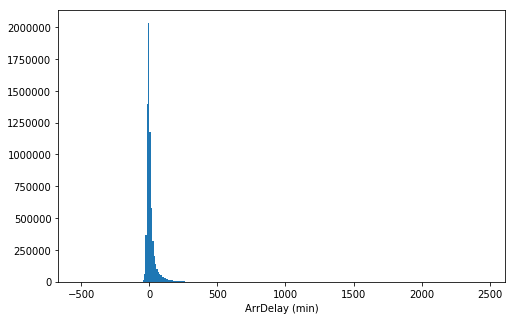

In [24]:
binsize = 10
bins = np.arange(df['ArrDelay'].min(), df['ArrDelay'].max()+binsize, binsize);
#print(bins)
plt.figure(figsize=[8, 5]);
plt.hist(data = df[np.isfinite(df['ArrDelay'])], x = 'ArrDelay', bins = bins);

plt.xlabel('ArrDelay (min)');
plt.show();


As expected, huge spike aroud zero, so let's zoom around it.

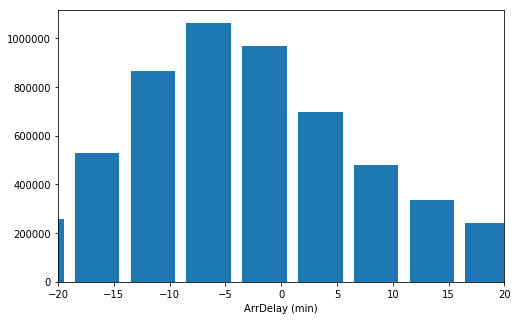

In [25]:
# Histogram plot
binsize = 5
bins = np.arange(df['ArrDelay'].min(), df['ArrDelay'].max()+binsize, binsize);
#print(bins)
plt.figure(figsize=[8, 5]);
plt.hist(data = df[np.isfinite(df['ArrDelay'])], x = 'ArrDelay', bins = bins, rwidth=0.8);
plt.xlabel('ArrDelay (min)');
plt.xticks(range(-30,30, binsize))
axes = plt.gca()
axes.set_xlim([-20,20])
plt.show();

The majority of planes landed early than expected.

There probably is a good reason for that, it's an interresting question to ask to a professional.


We first saw that the ArrDelay is right skewed with a slope with long tail that's look like a Landau distribution. https://en.wikipedia.org/wiki/Landau_distribution

So let's have a look to the ArrDelay at log scale.

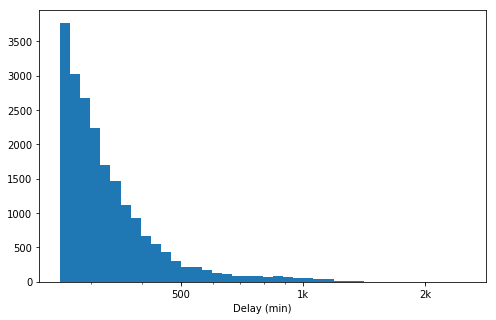

In [26]:
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(df['ArrDelay'].max())+log_binsize, log_binsize)
# Use non-equal bin sizes, such that they look equal on log scale.
# Thanks to https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.figure(figsize=[8, 5]);
plt.hist(data = df[np.isfinite(df['ArrDelay'])], x = 'ArrDelay', bins = bins);
plt.xscale('log');
plt.xticks([500, 1e3, 2e3], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Delay (min)');
plt.show();


Even at log scale, the delay time seems to derease rapidly.

The distribution still have the same shape. With many short delay and few long delay.

It's not surprising as it is what we could expect for such metrics.

So let's have a look at huge delay to saw what they look like :

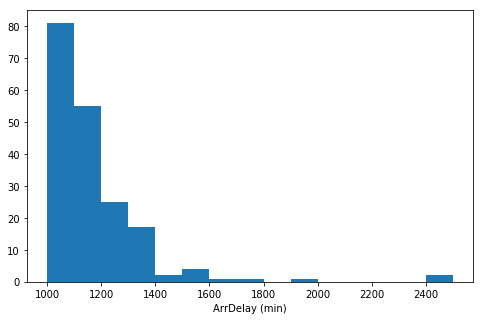

In [27]:
min_delay = 1000
df_hight_delay = df[np.isfinite(df['ArrDelay'])].query("ArrDelay > @min_delay")

binsize = 100
bins = np.arange(min_delay, df_hight_delay['ArrDelay'].max()+binsize, binsize);
plt.figure(figsize=[8, 5]);
plt.hist(data = df_hight_delay, x = 'ArrDelay', bins = bins);
plt.xlabel('ArrDelay (min)');
plt.show();


In [28]:
24*60
2400/60/24


1440

1.6666666666666667

The biggest outliers have a delay of more than a day and half.

But it coud have append, we will keep them.

Let's check closely, just in case.

In [29]:
df[np.isfinite(df['ArrDelay'])].query("ArrDelay > 1200")[['Month', 'CRSDepTime', 'DepTime',
       'DepDelay',
       'CRSArrTime','ArrTime', 'ArrDelay', 'UniqueCarrier',  
        'Origin',  
       ]].head(3)

,Month,CRSDepTime,DepTime,DepDelay,CRSArrTime,ArrTime,ArrDelay,UniqueCarrier,Origin
503727,1,1930,1805.0,1355.0,2215,2052.0,1357.0,AA,DEN
527950,1,1045,800.0,1275.0,1327,1452.0,1525.0,AA,EGE
996512,2,1420,1257.0,1357.0,1650,1527.0,1357.0,MQ,VPS


The hight delay flight seems real. But some of them are strange like flight who take off with a small delay but arrived with a huge delay of many hours.
For exemple, it's impossible for a plane to flight 10 hours when only 1 hour was expected at take off.

So we could supposed that the plane have landed on an another airport before going to the final airport.

Another strange behaviour at first look is when real departure time are before planed but with a huge positive delay. Well, it just means the plane has take off the day after it was expected.

I have found strange exemple but I think we could keep them because we have a huge dataset and the values are in an acceptable range.

## Build a classification of delay

To better undertand the delay I will classify them in bins for :
- Early (more than 15 minutes before expected)
- On Time (between, -15 and 5 minutes after)
- Small Delay (between 5 and 30)
- Medium Delay (between 30 and 90)
- Very late (above 90)
- Diverted : A diverted flight is one that has been routed from its original arrival destination to a new, typically temporary, arrival destination.
- Cancelled : Plane never takeof

In [30]:
# Thanks to https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable
# For building classification in Pandas.

# Set the categorical variable values
arr_status = ['Unknown', 'Early', 'On Time', 'Small Delay',
              'Medium Delay' ,'Very late', 'Diverted', 'Cancelled']
# Set default value
df['ArrStatus'] = 'Unknown';
_ = pd.Categorical(df.ArrStatus, categories=arr_status, ordered=True);
# Cancelled Flight
df.loc[(df['Cancelled'] == 1) , 'ArrStatus'] = 'Cancelled'
# Cancelled Flight
df.loc[(df['Diverted'] == 1) , 'ArrStatus'] = 'Diverted'
# Delayed flights
df.loc[(df['ArrDelay'] <= -15) , 'ArrStatus'] = 'Early (<-15)'
df.loc[(df['ArrDelay'] > -15) , 'ArrStatus'] = 'On Time (<15)'
df.loc[(df['ArrDelay'] > 5) , 'ArrStatus'] = 'Small Delay (5-30)'
df.loc[(df['ArrDelay'] > 30) , 'ArrStatus'] = 'Medium Delay (30-90)'
df.loc[(df['ArrDelay'] > 90) , 'ArrStatus'] = 'Very late (>90)'

Now, we can plot them.

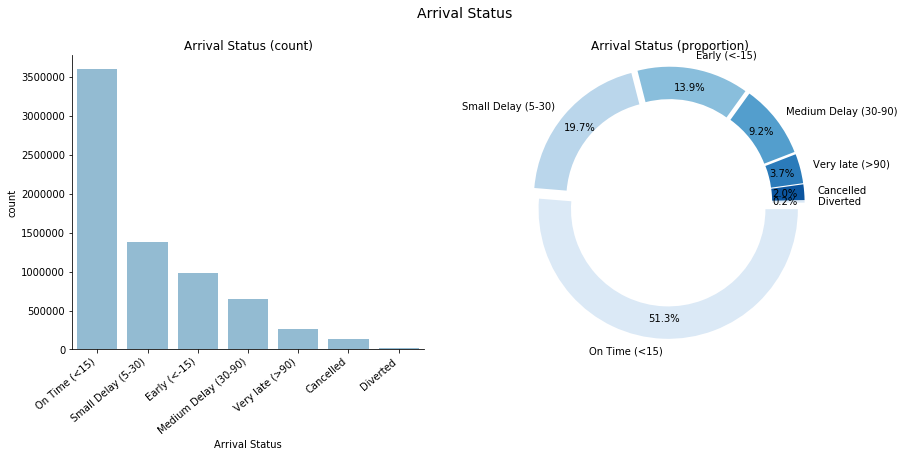

In [89]:
base_color = sns.color_palette("Blues")[2]
f,ax=plt.subplots(1,2,figsize=(13,6));
sns.countplot('ArrStatus',order = df['ArrStatus'].value_counts().index, data=df,ax=ax[0],
             color = base_color);
sns.despine(ax=ax[0])
#plt.xticks(rotation = 90)
# Thanks to https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Arrival Status (count)');
ax[0].set_xlabel('Arrival Status');

# Thanks to https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
#explosion
explode = []
for i in range(len(df['ArrStatus'].value_counts())):
    explode.append(0.05)

df['ArrStatus'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],
                                       wedgeprops = {'width' : 0.25},
                                       startangle = 0,
                                       counterclock = False,
                                       colors = sns.color_palette("Blues"),
                                       pctdistance=0.85, explode = explode);
ax[1].set_title('Arrival Status (proportion)');
ax[1].set_ylabel('');
# Equal aspect ratio ensures that pie is drawn as a circle
ax[1].axis('equal')  
plt.tight_layout()
plt.suptitle("Arrival Status", fontsize = 14, y = 1.05);

We learn that pie chart is not suited for too much bin, so let's group it a bit more.



In [32]:
df['ArrStatus_light'] = df['ArrStatus']

# Thanks to https://stackoverflow.com/questions/48345415/how-to-group-categorical-values-as-a-group-in-pandas
# For them replace method.
mapping = { 
    'On Time (<15)':'On Time',
    'Early (<-15)':'On Time',
    'Small Delay (5-30)':'Delayed',
    'Medium Delay (30-90)':'Delayed',
    'Very late (>90)':'Delayed',
    'Diverted':'Diverted or Cancelled',
    'Cancelled':'Diverted or Cancelled'
    }

df['ArrStatus_light'] = df['ArrStatus_light'].replace(mapping);
df.ArrStatus_light.value_counts()

On Time                  4571981
Delayed                  2283048
Diverted or Cancelled     154699
Name: ArrStatus_light, dtype: int64

And re-draw.

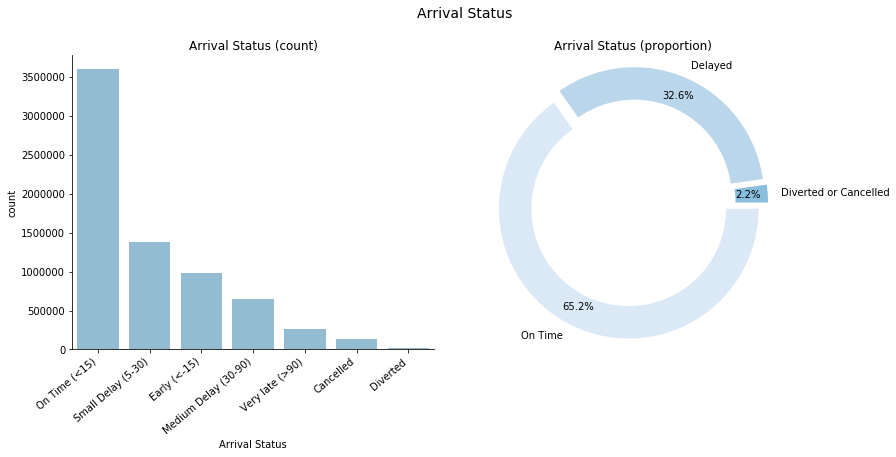

In [90]:
base_color = sns.color_palette("Blues")[2]
#sns.palplot(sns.color_palette("Blues"))

f,ax=plt.subplots(1,2,figsize=(13,6));
sns.countplot('ArrStatus',order = df['ArrStatus'].value_counts().index, data=df,ax=ax[0],
             color = base_color);
sns.despine(ax=ax[0])

# Thanks to https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Arrival Status (count)');
ax[0].set_xlabel('Arrival Status');

# Thanks to https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
#explosion
explode = []
for i in range(len(df['ArrStatus_light'].value_counts())):
    explode.append(0.05)

df['ArrStatus_light'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],
                                       wedgeprops = {'width' : 0.25},
                                       startangle = 0,counterclock = False,
                                       colors = sns.color_palette("Blues"),
                                       pctdistance=0.85, explode = explode);
ax[1].set_title('Arrival Status (proportion)');
ax[1].set_ylabel('');
ax[1].axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.suptitle("Arrival Status", fontsize = 14, y = 1.05);

Only 2.2% of flights where Diverted or Cancelled.

But more than 30% get delayed by more than 5 minutes.

More than 15% are delayed by more than 30 minutes. I think it's too much.

But there is quite the same proportion of flight that land in advance.



## Filter the dataset

Let's build a dataframe with only dealayed flights as we will focus on them.

In [34]:
df_late = df[df.ArrStatus_light == 'Delayed']

## Build methods to draw viz

To be able to explore faster and change all graph in one time, I build method for frequent plot.

It also allows me to plot the late data over the whole dataset to get insight on correlation, while on univariate exploration.

In [35]:
import matplotlib.patches as mpatches

_ = sns.axes_style("whitegrid")

def histogram_continuous_variable(column_name, binsize = 100, legend=''):
    bins = np.arange(df[column_name].min(), df[column_name].max()+binsize, binsize);
    #plt.figure(figsize=[8, 5]);
    plt.hist(data = df_late, x = column_name, bins = bins, label=legend);
    plt.title('Flights count per ' + column_name, fontsize=18);
    legend = column_name if legend == '' else legend
    plt.xlabel('Minutes');
    plt.ylabel('Count');
    plt.xlim([20,200]);
    plt.ylim([0,20000]);
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def comparative_histogram_continuous_variable(column_name, binsize = 100, xlabel=''):
    global df, df_late
    bins = np.arange(df[column_name].min(), df[column_name].max()+binsize, binsize);
    plt.figure(figsize=[13, 5]);
    plt.hist(data = df, x = column_name, bins = bins);
    ax = plt.hist(data = df_late, x = column_name, bins = bins);
    plt.title('Flights count per ' + column_name, fontsize=18);
    xlabel = column_name if xlabel == '' else xlabel
    plt.xlabel(xlabel);
    plt.ylabel('Count');
    blue_patch = mpatches.Patch(color='darkslateblue', label='All')
    red_patch = mpatches.Patch(color='indianred', label='Delayed')
    plt.legend(handles=[blue_patch, red_patch])

def comparative_barchart_categorical_variable(column_name, xlabel=''):
    global df, df_late
    plt.figure(figsize=[13, 5]);
    xlabel = column_name if xlabel == '' else xlabel
    ax1 = sns.countplot(x=column_name, color='darkslateblue', data=df);
    sns.despine(ax=ax1)
    ax2 = sns.countplot(x=column_name, color='indianred', data=df_late);
    sns.despine(ax=ax2)
    plt.title('Flights count per ' + column_name, fontsize=18);
    plt.xlabel(xlabel, labelpad=16);
    plt.ylabel('Count', labelpad=16);
    ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right')
    blue_patch = mpatches.Patch(color='darkslateblue', label='All')
    red_patch = mpatches.Patch(color='indianred', label='Delayed')
    plt.legend(handles=[blue_patch, red_patch])

## Check Month

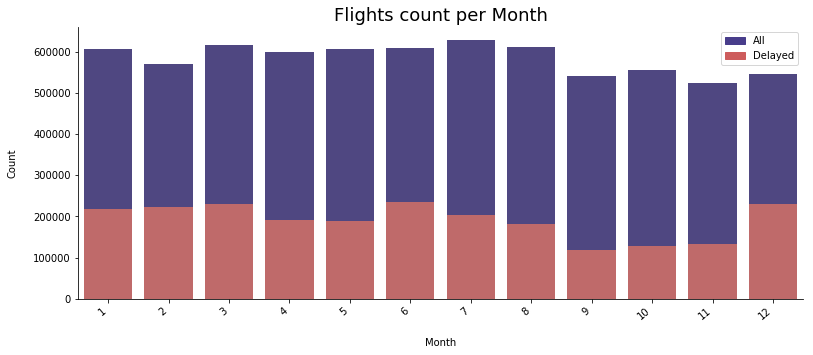

In [36]:
comparative_barchart_categorical_variable('Month');

Flights vary a little bit between month.

It seems to have more delay in December. But it's a count of flights, we may look at it in bi-variate exploration.

## Check Day of Month

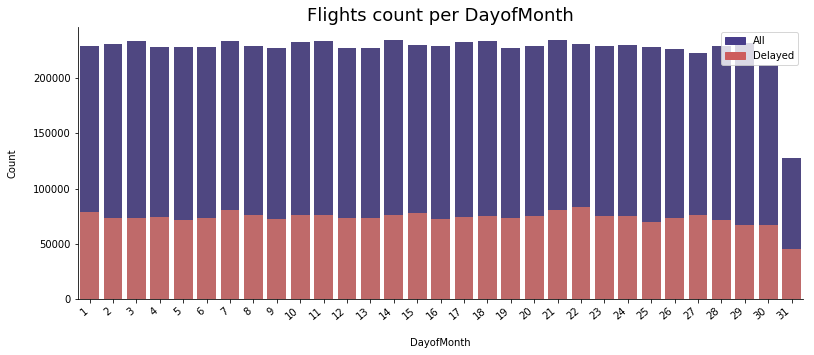

In [37]:
comparative_barchart_categorical_variable('DayofMonth');

We have less count for the 31th day of month. It's normal because not all month has 31 days.

Don't seems to have correlation between Day Of Month and delay. But it's not surprising as day of month over the year don't mean much for human activity in our case.

## Check Day of Week

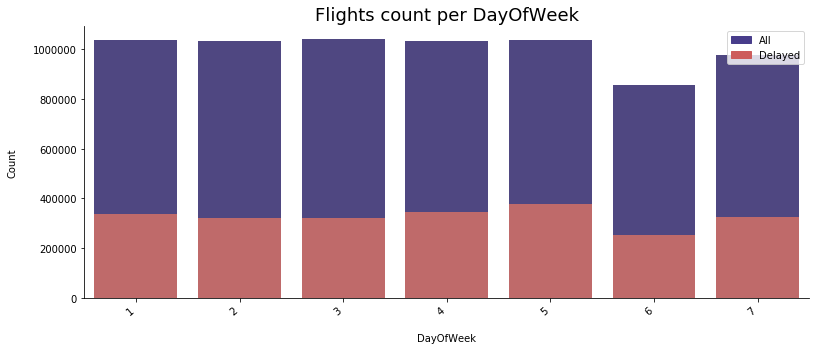

In [38]:
comparative_barchart_categorical_variable('DayOfWeek');

I have checked that in the datas, 1 is Monday and 7 Sunday.

We saw that there is less flights on Saterday. And it seems to have more delayed flights on Friday.

## Check Departure Time

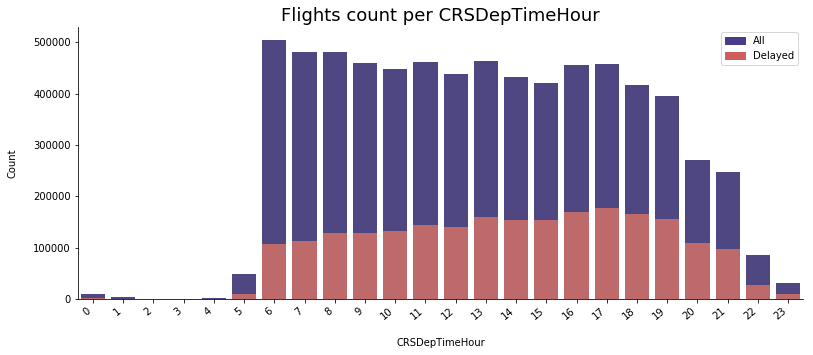

In [39]:
comparative_barchart_categorical_variable('CRSDepTimeHour');

There is almost no takeoff in early night. Then it suddently grow up around 6 am.

There are more flights at 6 in the morning, but more delay in the evening. It will be interesting to look at this in bi-variate exploration.

## Check Carrier

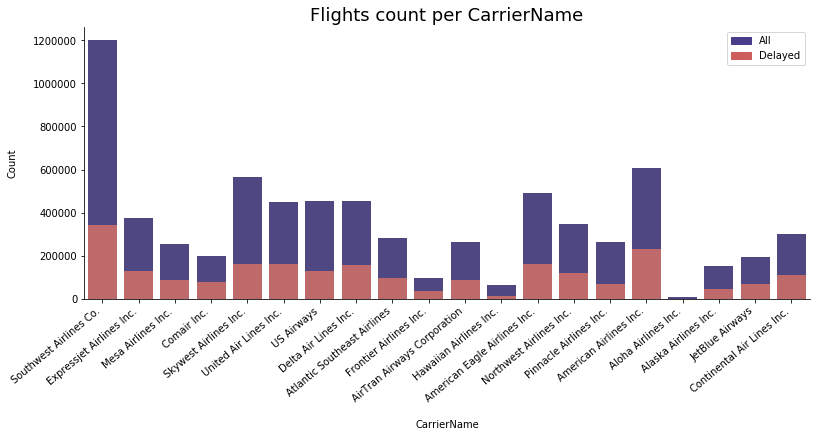

In [40]:
comparative_barchart_categorical_variable('CarrierName')

Here we saw that Southwest airline is the carrier with most flights, far above the others.

And we saw a correlation between carrier and delay : American Airline, despite operating half of Southwest Airline, has almost the same delayed flights.

## Reason of Cancellation 

I will create a new column with the label of cancellation code.

In [41]:
df['CancellationReason'] = df['CancellationCode']

# Thanks to https://stackoverflow.com/questions/48345415/how-to-group-categorical-values-as-a-group-in-pandas
mapping = { 
    'A':'Carrier',
    'B':'Weather',
    'C':'National Air System',
    'D':'Security'
    }

df['CancellationReason'] = df['CancellationReason'].replace(mapping);

Then, plot it.

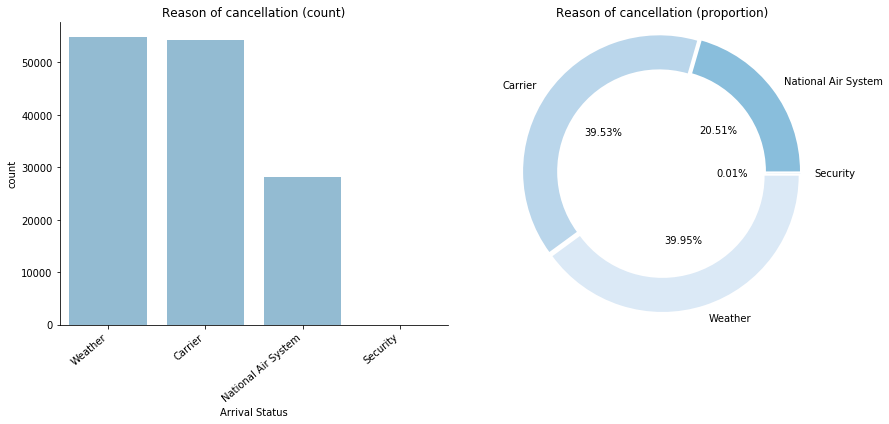

In [42]:
base_color = sns.color_palette("Blues")[2]

f,ax=plt.subplots(1,2,figsize=(13,6));
#with sns.axes_style("whitegrid"):
axp = sns.countplot('CancellationReason', order = df['CancellationReason'].value_counts().index,
                    data=df, ax=ax[0], color = base_color);
sns.despine(ax=axp)
axp.set_title('Reason of cancellation (count)');
axp.set_xlabel('Arrival Status');
axp.set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right");

# Thanks to https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
#explosion
explode = []
for i in range(len(df['CancellationReason'].value_counts())):
    explode.append(0.02)

df['CancellationReason'].value_counts().plot.pie(autopct='%1.2f%%',ax=ax[1],
                                       wedgeprops = {'width' : 0.25},
                                       startangle = 0, counterclock = False,
                                       colors = sns.color_palette("Blues"),
                                       pctdistance=0.50, explode = explode);

ax[1].set_title('Reason of cancellation (proportion)');
ax[1].set_ylabel('');
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right");
# Equal aspect ratio ensures that pie is drawn as a circle
ax[1].axis('equal')  
plt.tight_layout()
plt.show();


I was expecting more cancellation for security reason. But it almost never append.

Weather and Carrier are equaly responsible of delay.

I was surprised by the amount of NAS cancellation. According to http://www.flightbucks.com/blog/9-biggest-causes-of-flight-delays-or-cancellations This might include non-severe weather events, heavy air traffic, air traffic control delays, and airport operations. 

20% is huge but we have to remember that it's 20% of cancellation, wich occure only 2% of flights.

## Mosts used plane (TailNum)

TailNum is the identification of a plane.

In [43]:
import itertools
vc = df.TailNum.value_counts()
print('Number of plane :', len(vc))
print('\n5 mosts used plane')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,5):
      print(name, cnt)

Number of plane : 5373

5 mosts used plane
N476HA 4701
N477HA 4548
N484HA 4505
N475HA 4499
N480HA 4416


In [44]:
4701/365

12.87945205479452

N476HA is the most often used plane : 4 701 times in 2008, it's 12 flights per day !

Having a look at https://www.flightradar24.com/data/aircraft/n476ha it is a plane that do rotation between Hawai islands. Not a bad place to fly !

I did not know that an airplane could fly so much in one day.

## Mosts frequent flight (FlightNum)

TailNum is the identification of a plane.

In [45]:
import itertools
vc = df.FlightNum.value_counts()
print('Number of flight in 2008:', len(vc))
print('\n5 mosts frequent flight :')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,5):
      print(name, cnt)

Number of flight in 2008: 7539

5 mosts frequent flight :
152 4883
12 4793
16 4717
511 4621
308 4449


Let's look at the most frequent :

In [46]:
df.query("FlightNum == '152'").head(3)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,DestState,DestLat,DestLong,CarrierName,OriginStateName,DestStateName,CRSDepTimeHour,ArrStatus,ArrStatus_light,CancellationReason
1180,1,3,4,625.0,625,741.0,735,WN,152,N379SW,...,CA,37.361862,-121.929009,Southwest Airlines Co.,California,California,6,Small Delay (5-30),Delayed,NaN
1983,1,3,4,805.0,755,952.0,1005,WN,152,N379SW,...,WA,47.448982,-122.309313,Southwest Airlines Co.,California,Washington,7,On Time (<15),On Time,NaN
4618,1,4,5,632.0,625,803.0,735,WN,152,N344SW,...,CA,37.361862,-121.929009,Southwest Airlines Co.,California,California,6,Small Delay (5-30),Delayed,NaN


"152" is the most frequent flight.

I thought that Flight Number represented a flight from an airport to another for a specific company at a specific time. But data show that it's not always the same destination, nor the same company.

## 10 mosts used origin City

In [47]:
import itertools
vc = df.OriginCity.value_counts()
print('Number of Origin airport :', len(vc))
print('\n10 mosts used origin airport')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

Number of Origin airport : 288

10 mosts used origin airport
Chicago 437999
Atlanta 414513
Dallas-Fort Worth 281281
Denver 241443
Houston 241105
New York 237939
Los Angeles 215608
Phoenix 199408
Las Vegas 172876
Detroit 161989


Chicago and Atlanta are the city with most departure.

## Destination

In [48]:
import itertools
vc = df.DestCity.value_counts()
print('Number of Dest airport :', len(vc))
print('\n10 mosts used Dest airport')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

Number of Dest airport : 289

10 mosts used Dest airport
Chicago 438052
Atlanta 414521
Dallas-Fort Worth 281401
Denver 241470
Houston 241094
New York 237919
Los Angeles 215685
Phoenix 199416
Las Vegas 172871
Detroit 162000


Not surprisingly, Chicago and Atlanta are the cities with most arrival.

We note that we have 288 departure cities but 289 destination city. That's a sort of outlier.

## Distance

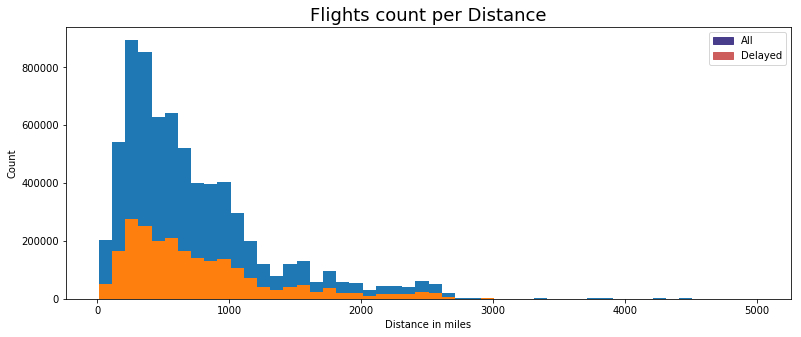

In [49]:
comparative_histogram_continuous_variable('Distance', xlabel='Distance in miles')

Majority of flights are for less than 500 miles, around 1 000 km.

Delay count seams to follow the distance in the same proportion.

Having flight distance above 3 000 miles for domestics flights is strange, let's look at them :

In [50]:
df.query("Distance > 4000").head(3)

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,DestState,DestLat,DestLong,CarrierName,OriginStateName,DestStateName,CRSDepTimeHour,ArrStatus,ArrStatus_light,CancellationReason
218178,1,1,2,1030.0,1010,1541.0,1522,UA,1,N213UA,...,HI,21.318691,-157.922407,United Air Lines Inc.,Illinois,Hawaii,10,Small Delay (5-30),Delayed,NaN
218179,1,2,3,1037.0,1010,1535.0,1522,UA,1,N211UA,...,HI,21.318691,-157.922407,United Air Lines Inc.,Illinois,Hawaii,10,Small Delay (5-30),Delayed,NaN
218180,1,3,4,1028.0,1010,1515.0,1522,UA,1,N212UA,...,HI,21.318691,-157.922407,United Air Lines Inc.,Illinois,Hawaii,10,On Time (<15),On Time,NaN


No error here : it's the flights from and to Hawai.

# Reason of delay 

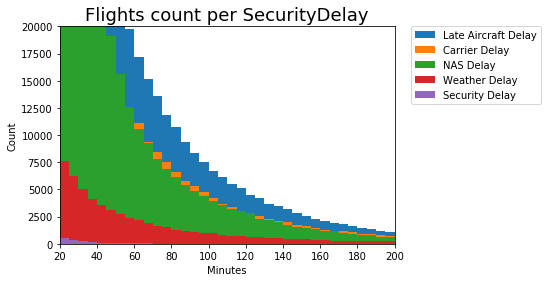

In [51]:
histogram_continuous_variable('LateAircraftDelay', binsize=5, legend='Late Aircraft Delay')
histogram_continuous_variable('CarrierDelay', binsize=5, legend='Carrier Delay')
histogram_continuous_variable('NASDelay', binsize=5, legend='NAS Delay')
histogram_continuous_variable('WeatherDelay', binsize=5, legend='Weather Delay')
histogram_continuous_variable('SecurityDelay', binsize=5, legend='Security Delay')

The distribution is quite the same for all delay.

Let's have a different look.

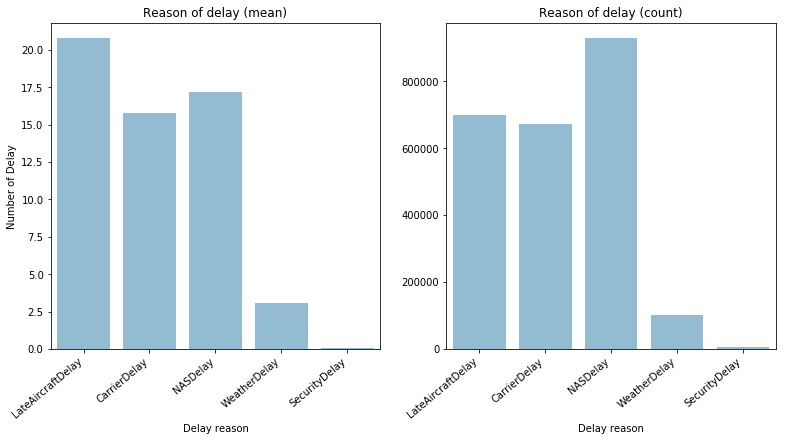

In [83]:
reasons = ['LateAircraftDelay', 'CarrierDelay', 'NASDelay', 'WeatherDelay', 'SecurityDelay' ]

# Compute the mean and count of reason.
name = []
sum_delay = []
num_delay = []
for reason in reasons:
    name.append(reason)
    sum_delay.append(df_late[reason].mean())
    num_delay.append(
        len( df_late.query(reason + " > 0") )
    )

fig,ax=plt.subplots(1,2,figsize=(13,6));
sns.barplot(x=name, y=sum_delay, ax=ax[0], color=sns.color_palette("Blues")[2]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Reason of delay (mean)');
ax[0].set_xlabel('Delay reason');
ax[0].set_ylabel('Mean of Delay in min');

sns.barplot(x=name, y=num_delay, ax=ax[1], color=sns.color_palette("Blues")[2]);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Reason of delay (count)');
ax[1].set_xlabel('Delay reason');
ax[0].set_ylabel('Number of Delay');

We must be careful about these data as we have many missing values for them. I don't know if it means that it was 0 or unregistered values.

Late Aircraft delay is the one causing the more delay, on average. But NAS Delay is the most frequent delay.

It's a real problem, we saw that delay are causing more delay. Maybe company need to be incentived to reduce delay by flying faster, even if it cost, to reduce them ?

There is almos no Security Delay. That's something I feel strange about it. I thing there is missing data about it.

---

Here is some information of the delay reason from https://aspmhelp.faa.gov/index.php/Types_of_Delay :

**Carrier Delay** is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, baggage, bird strike, cargo loading, and so on...


**Late Aircraft Delay** at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.


**NAS Delay** is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET.


**Security delay** is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.


**Weather delay** is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival. 

---

So  maybe we could assume that if there is less than 29 min of delay due to security check, it's not took as "security delay" ?

### Drop unnessary data.

In [53]:
df_late.drop(['DepTime', 'ArrTime', 'CRSArrTime', 'DepDelay', ], axis=1, inplace=True)

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The ArrDelay seems clean and tidy, I do not plan to remove points.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I did not saw unusual distribution.

I saw data that seems strange but investigation give me me legit answers.

I will not investigate Flight Num as it not representing something usefull.

I have build categorical feature to help better understand the delay by putting flight in bins of different delay.

I will also build a categorical variable for season, based on month to study winter delay.

# Bivariate Exploration

I will no study delay versus another variable.

Let's begin with specific plane to see if there is plane more subject to delay.

## TailNum study

In [54]:
def plot_categorical_variable(df_data, x_column_name, y_column_name, xlabel='', ylabel='', title=''):
    plt.figure(figsize=[13, 5]);
    xlabel = x_column_name if xlabel == '' else xlabel
    ylabel = y_column_name if ylabel == '' else ylabel
    ax1 = sns.barplot(x=x_column_name, y=y_column_name, color= sns.color_palette("Blues")[2], data=df_data);
    sns.despine(ax=ax1)
    plt.title(title, fontsize=18);
    plt.xlabel(xlabel, labelpad=16);
    plt.ylabel(ylabel, labelpad=16);
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right')

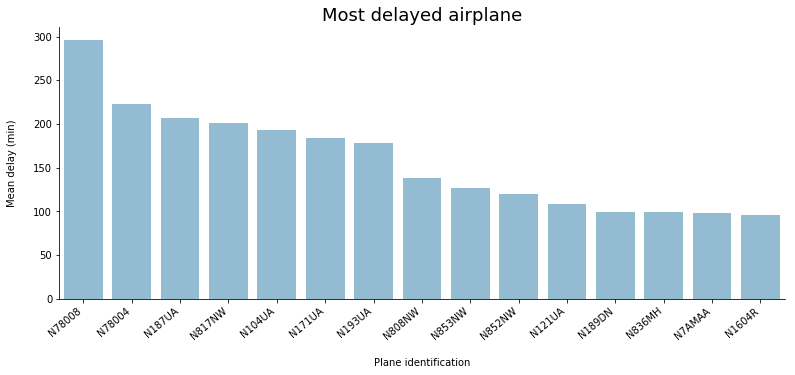

In [55]:
df_late_plane = df_late.groupby(['TailNum'])['ArrDelay'].mean().sort_values(ascending = False).reset_index();

plot_categorical_variable(df_late_plane[:15], 'TailNum', 'ArrDelay', 'Plane identification', 'Mean delay (min)', title='Most delayed airplane')

It seems you have to avoid flying with airplane N78008 as he land with a mean delay of 5 hours !

We could get info of the plane on https://www.planespotters.net/airframe/Boeing/777/N78008-United-Airlines/D7dbtJWO

It's a Boeing 777-200 build in 1999.

Let's check it in detail :

In [56]:
df_late.query("TailNum == 'N78008'")

,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,...,DestCity,DestState,DestLat,DestLong,CarrierName,OriginStateName,DestStateName,CRSDepTimeHour,ArrStatus,ArrStatus_light
6981780,12,17,3,1030,CO,40,N78008,296.0,IAH,EWR,...,Newark,NJ,40.692497,-74.168661,Continental Air Lines Inc.,Texas,New Jersey,10,Very late (>90),Delayed


And here we learn that our result was clearly not statisticaly significant : this plane only made one flight !
    
Let's take only plane with more than 200 flights.

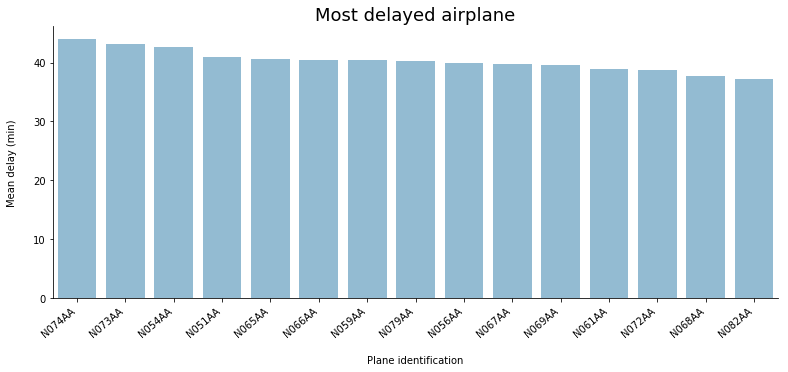

In [57]:
# Get the plane with more than 200 flight in the main dataset
df_most_flights = df.groupby(['TailNum'])['Month'].count().sort_values(ascending = False).reset_index();
df_most_flights = df_most_flights.query("Month > 200")
# Filter the df_late dataset for them
df_late_plane = df[df['TailNum'].isin(df_most_flights['TailNum'])]
# Compute the delay mean for them
df_late_plane = df_late_plane.groupby(['TailNum'])['ArrDelay'].mean().sort_values(ascending = False).reset_index();
# Plot the top 15
plot_categorical_variable(df_late_plane[:15], 'TailNum', 'ArrDelay', 'Plane identification', 'Mean delay (min)', title='Most delayed airplane')

Now we have a better list of plane to avoid. Still with a mean of almost one hour late.

Let's have a look to less delayed plane.

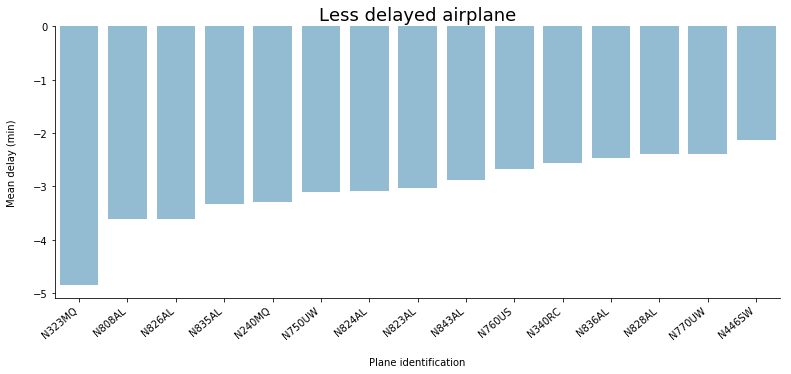

In [58]:
df_late_plane = df_late_plane.groupby(['TailNum'])['ArrDelay'].mean().sort_values(ascending = True).reset_index();
# Plot the top 15
plot_categorical_variable(df_late_plane[:15], 'TailNum', 'ArrDelay', 'Plane identification', 'Mean delay (min)', title='Less delayed airplane')

OK, at the other side of the graph we have always in advance plane in average.

Let's do the same for Carrier.

## Carrier

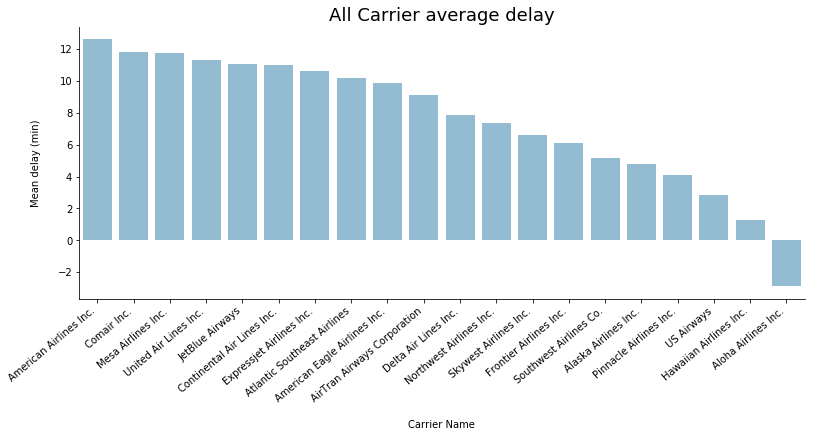

In [59]:
# Get the Carrier with more than 1000 flights in the main dataset
df_most_flights = df.groupby(['CarrierName'])['Month'].count().sort_values(ascending = False).reset_index();
df_most_flights = df_most_flights.query("Month > 500")
# Filter the df dataset for them
df_late_plane = df[df['CarrierName'].isin(df_most_flights['CarrierName'])]
# Compute the delay mean for them
df_late_plane = df_late_plane.groupby(['CarrierName'])['ArrDelay'].mean().sort_values(ascending = False).reset_index();
# Plot the top 15
plot_categorical_variable(df_late_plane, 'CarrierName', 'ArrDelay', 'Carrier Name', 'Mean delay (min)', title='All Carrier average delay')

JetBlue is the company with the more delay on average : more than 50 minutes.

While Aloha Airline are landind early on average !

If I look only at top 3 carriers, who operate more than 500 000 flights per year, we have :
- American Airline are 13 minutes late on average
- SkyWest 6 min
- SouthWest 5 min

So, based on that, we could say that you have to avoid American Airline to be on time.

## Season delay

In [60]:
# Thanks to https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable

def create_season(df):
    # Set the categorical variable values
    season = ['Spring', 'Summer', 'Fall', 'Winter', 'Unknown']
    # Set default value
    df['Season'] = 'Unknown';
    _ = pd.Categorical(df.Season, categories=season, ordered=True);

    df.loc[(df['Month'] == 3) , 'Season'] = 'Spring'
    df.loc[(df['Month'] == 4) , 'Season'] = 'Spring'
    df.loc[(df['Month'] == 5) , 'Season'] = 'Spring'

    df.loc[(df['Month'] == 6) , 'Season'] = 'Summer'
    df.loc[(df['Month'] == 7) , 'Season'] = 'Summer'
    df.loc[(df['Month'] == 8) , 'Season'] = 'Summer'

    df.loc[(df['Month'] == 9) , 'Season'] = 'Fall'
    df.loc[(df['Month'] == 10) , 'Season'] = 'Fall'
    df.loc[(df['Month'] == 11) , 'Season'] = 'Fall'

    df.loc[(df['Month'] == 12) , 'Season'] = 'Winter'
    df.loc[(df['Month'] == 1) , 'Season'] = 'Winter'
    df.loc[(df['Month'] == 2) , 'Season'] = 'Winter'

create_season(df);
create_season(df_late);
df['Season'].value_counts();
df_late['Season'].value_counts();

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


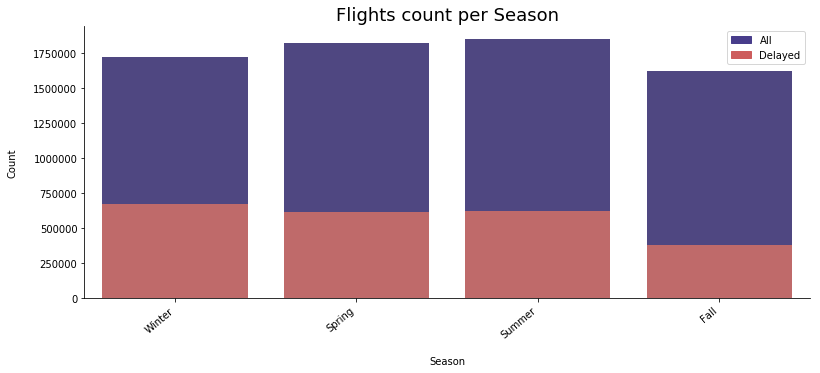

In [61]:
comparative_barchart_categorical_variable('Season')

There is less flight in Spring than in winter, but more delay.

Let's look at Violin plot.

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


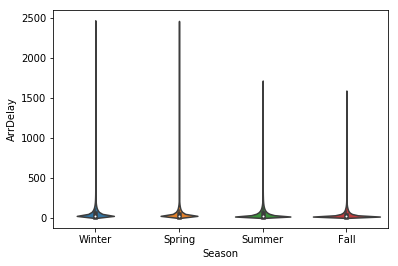

In [62]:
sns.violinplot(data = df_late, x = 'Season', y = 'ArrDelay');

We can't see nothing with default parameters.

Let's keep only delay between 10 minutes and 100 minutes.

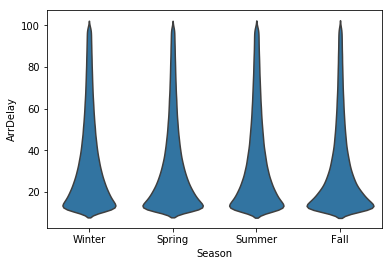

In [63]:
base_color = sns.color_palette()[0]
sns.violinplot(data = df_late.query("ArrDelay > 10 and ArrDelay < 100"), x = 'Season', y = 'ArrDelay', color = base_color,
              inner = None);

We don't see much more info, let's switch to WeatherDelay instead of ArrDelay.

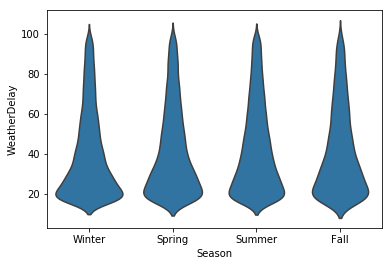

In [64]:
base_color = sns.color_palette()[0]

sns.violinplot(data = df_late.query("WeatherDelay > 15 and WeatherDelay < 100"), x = 'Season', y = 'WeatherDelay', color = base_color,
              inner = None);

We don't see much more info, let's switch to a boxplot.

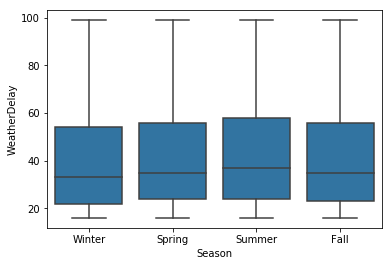

In [65]:
base_color = sns.color_palette()[0]

sns.boxplot(data = df_late.query("WeatherDelay > 15 and WeatherDelay < 100"), x = 'Season',
            y = 'WeatherDelay', color = base_color, showfliers=False);

Here we see a correlation. Being french I was expected to have more delay in Winter, due to snow, but it's in Summer and Fall.

I have forgotten that there are hurricanes in US in theses season.

And airplane are very impacted by hurricane.

But I feel strange about it, let's look at ArrDelay in the whole dataset, not only WeatherDelay.

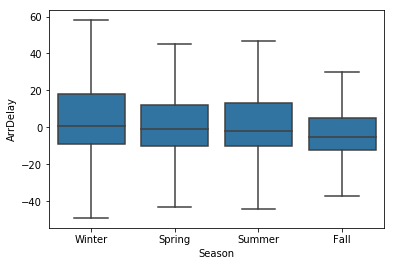

In [66]:
base_color = sns.color_palette()[0]

sns.boxplot(data = df, x = 'Season',
            y = 'ArrDelay', color = base_color, showfliers=False);

OK, here we saw more delay in Winter, so we could expect that we are missing WeatherDelay data.

## City

Let's explore delay by city.

My goal is to plot a box plot of the top 10 city with most delay.

I will compute on order index based on delay mean, then use it to plot.

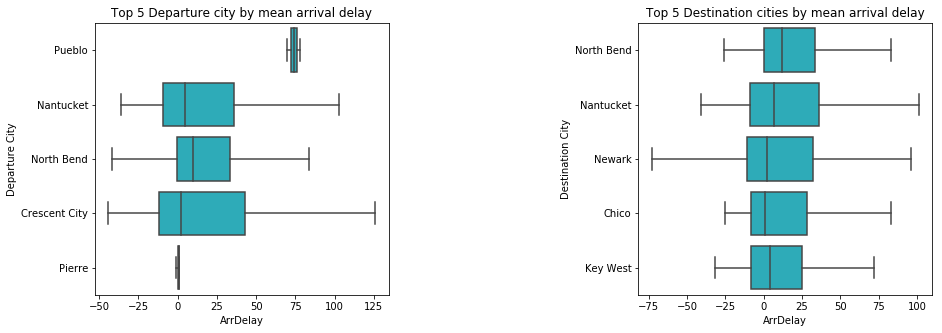

In [67]:
# 1 Compute the order by delay mean
delay_origin_city_order = df.groupby(['OriginCity'])['ArrDelay'].mean().sort_values(ascending = False).index[:5]
delay_dest_city_order = df.groupby(['DestCity'])['ArrDelay'].mean().sort_values(ascending = False).index[:5]

# Initiate a figure
plt.figure(figsize = [15, 5])
plt.subplots_adjust(wspace = 0.85) # adjust spacing between subplots, in order to show long city names nicely
# Draw the first boxplot
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(x = df['ArrDelay'], y = df['OriginCity'], order = delay_origin_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.ylabel('Departure City')
plt.title('Top 5 Departure city by mean arrival delay');

# draw the second
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(x = df['ArrDelay'], y = df['DestCity'], order = delay_dest_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.ylabel('Destination City')
plt.title('Top 5 Destination cities by mean arrival delay');

Pueblo is the origin city with most delay, but North Bend is the Destination with most delay, with 75% of late arrival.

Pueblo and Pierre look like outlier based on the shape of the box plot.

To avoid outliers of these small airport, I will only took the top 50 airports by flights count, then filter the dataset with it.

Then, I will compute an order based on mean delay.

And use it to display the plot.

So the order will not be by the biggest airport, but by the delay mean of the biggest airport.

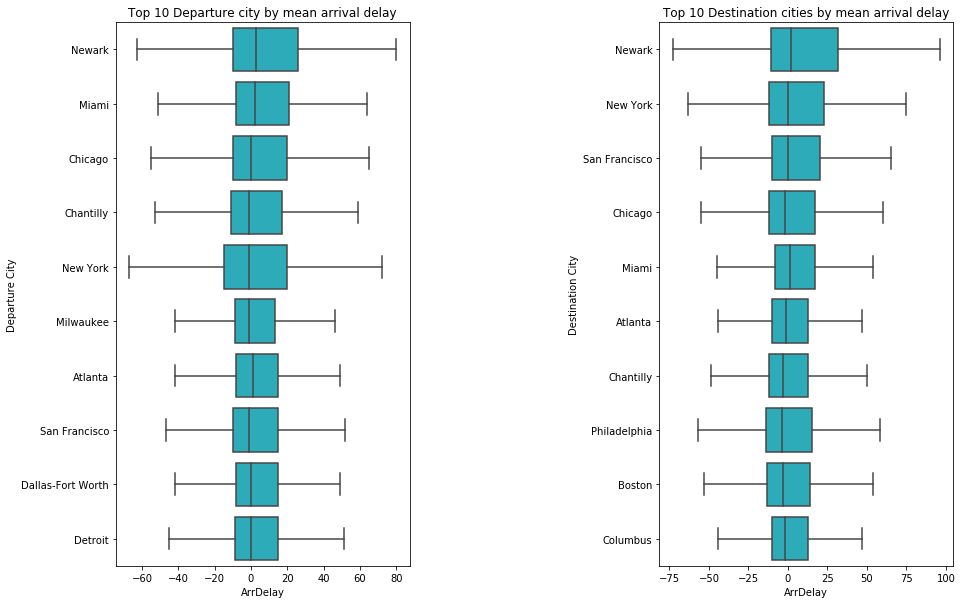

In [68]:
## 1 Filter the city with most flights
# Get the 50 cities with with most flights
df_most_flights = df.groupby(['OriginCity'])['Month'].count().sort_values(ascending = False).reset_index();
df_most_flights = df_most_flights[:50]
# Filter the dataset on them
df_late_ori_city = df[df['OriginCity'].isin(df_most_flights['OriginCity'])]
df_late_dest_city = df[df['DestCity'].isin(df_most_flights['OriginCity'])]

# 2 Compute the order by delay mean
delay_origin_city_order = df_late_ori_city.groupby(['OriginCity'])['ArrDelay'].mean().sort_values(ascending = False).index[:10]
delay_dest_city_order = df_late_dest_city.groupby(['DestCity'])['ArrDelay'].mean().sort_values(ascending = False).index[:10]

# Initiate a figure
plt.figure(figsize = [15, 10])
plt.subplots_adjust(wspace = 0.85) # adjust spacing between subplots, in order to show long city names nicely
# Draw the first boxplot
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(x = df_late_ori_city['ArrDelay'], y = df_late_ori_city['OriginCity'], order = delay_origin_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.ylabel('Departure City')
plt.title('Top 10 Departure city by mean arrival delay');

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(x = df_late_dest_city['ArrDelay'], y = df_late_dest_city['DestCity'], order = delay_dest_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.ylabel('Destination City')
plt.title('Top 10 Destination cities by mean arrival delay');

Newark is the departure city where, in average, you have to expect to be late.

But the distribution is large : you have more than 25% chance to arrive early.

If it's your destination, you also have to expect to be late, in more than 50% of the flights, in average.

What is interesting is some of top departure with hight mean delay are not in the Top 10 for destination, like Milwaukee.

Let's look to the other side, to major airport with lowest mean delay.

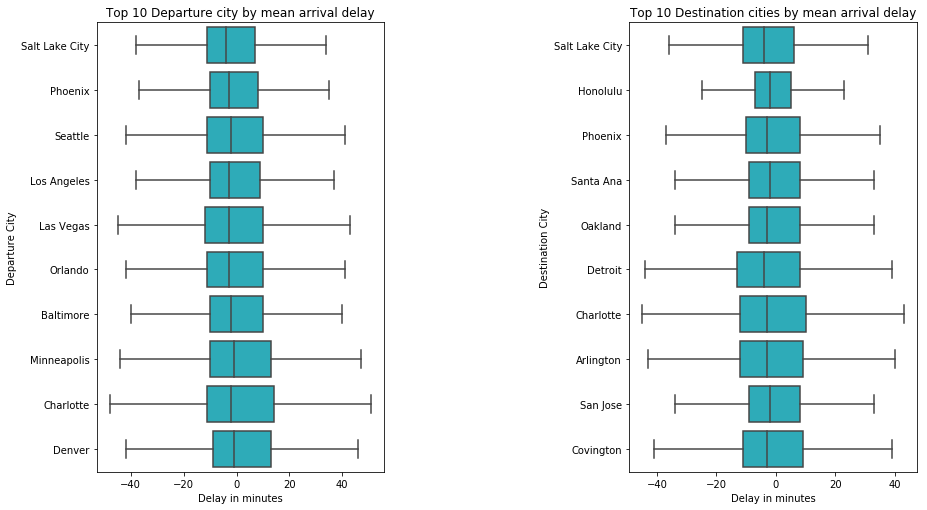

In [119]:

# 2 Compute the order by delay mean
delay_origin_city_order = df_late_ori_city.groupby(['OriginCity'])['ArrDelay'].mean().sort_values(ascending = True).index[:10]
delay_dest_city_order = df_late_dest_city.groupby(['DestCity'])['ArrDelay'].mean().sort_values(ascending = True).index[:10]

# Initiate a figure
plt.figure(figsize = [14.70, 8.27])
plt.subplots_adjust(wspace = 0.85) # adjust spacing between subplots, in order to show long city names nicely
# Draw the first boxplot
plt.subplot(1, 2, 1)
ax1 = sns.boxplot(x = df_late_ori_city['ArrDelay'], y = df_late_ori_city['OriginCity'], order = delay_origin_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.xlabel('Delay in minutes')
plt.ylabel('Departure City')
plt.title('Top 10 Departure city by mean arrival delay');

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(x = df_late_dest_city['ArrDelay'], y = df_late_dest_city['DestCity'], order = delay_dest_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.xlabel('Delay in minutes')
plt.ylabel('Destination City')
plt.title('Top 10 Destination cities by mean arrival delay');

Honolulu is a good destination, with 99% chance to have less than 25 minutes delay.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

I found that the plane you take influence on delay. But it's only statistics, they probalbly doesn't do the same type of flight, nor be the same model operated by the same company... It's difficult to draw individual conclusion like this. We arrive in the domain of machine learning.

For major Carrier we could have a better confidence in our conclusion as American Airline is twice late in average than SkyWest or SouthWest.

Season have an influence on delay : you are more subject to delay in winter. But we are clearly missing WeatherDelay info to be sure.

Airport seems to have an influence on delay.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

No, I have not tried to find them.

I could say there is strong correlation between ArrDelay and other delay columns but it's obvious.

# Multivariate Exploration

I will have a look to three variables at the same time to see if there is relationship between our previous observations.

## Delay by Carrier by City

As we have previously build "df_most_flights" with the most used city, we will use it to draw a plot of the delay by city and carrier.

The Seaborn Heatmap is good for that.

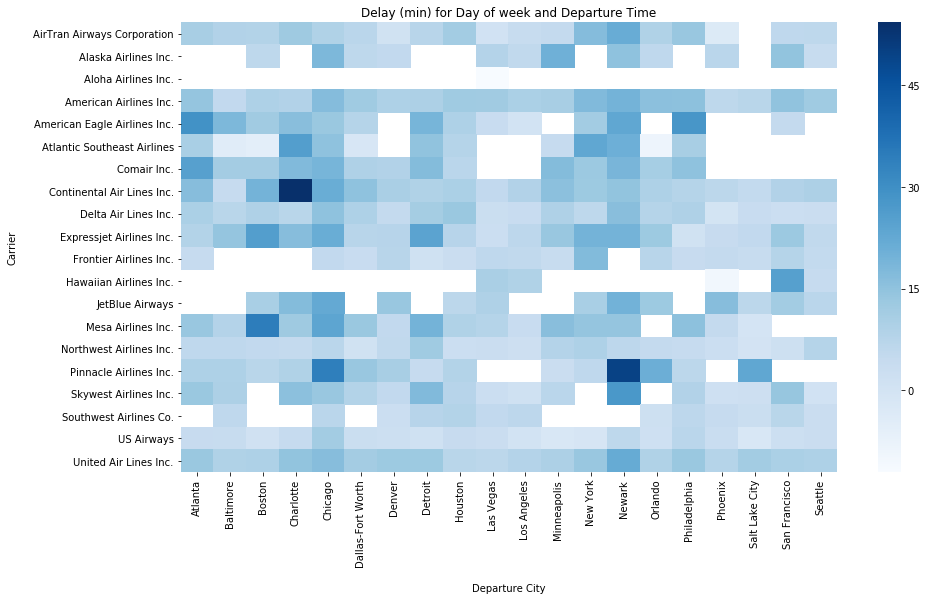

In [118]:
plt.figure(figsize=(14.70, 8.27))

df_most_flights = df_most_flights[:20]
# Filter the dataset on them
df_late_ori_city = df[df['OriginCity'].isin(df_most_flights['OriginCity'])]

df_group = df_late_ori_city.groupby(['CarrierName', 'OriginCity'])['ArrDelay'].mean().reset_index();
df_pivot = df_group.pivot('CarrierName', 'OriginCity', 'ArrDelay');

heat_map = sns.heatmap(df_pivot, cmap = 'Blues');

plt.title('Delay (min) for Day of week and Departure Time');
plt.xlabel('Departure City', labelpad = 16);
plt.ylabel('Carrier',  labelpad = 16);

Continental Airlines is causing more delay in Charlotte.

We clearly see Newark in the top delayed city. Now we see that "Pinnacle Airline" is responsible of the majority of delay there. And also in other city like Chicago or Salt Lake City.

That's realy interresting because "Pinnacle Airline" was far from the top of delay by carrier.

And American Airlines that sit on the top of delay by carrier don't show up here.

We have to remember that it's a plot only on the top 20 most frequently used city. So we could expect that American Airlines is causing more delay on small airport.

## Day of week and DepTime and Delay

I will use the same technic to view the delay by day of week and hour of day.

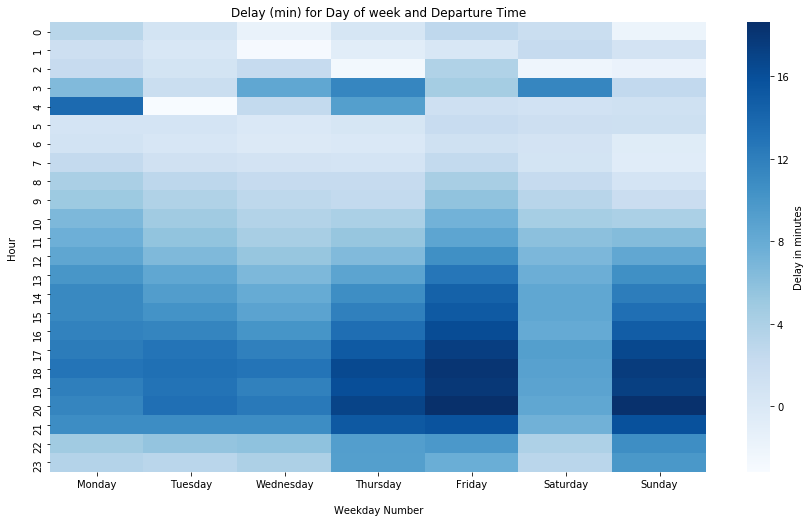

In [117]:
plt.figure(figsize=(14.70, 8.27))
df_group = df.groupby(['CRSDepTimeHour', 'DayOfWeek'])['ArrDelay'].mean().reset_index();
df_pivot = df_group.pivot('CRSDepTimeHour', 'DayOfWeek', 'ArrDelay');

heat_map = sns.heatmap(df_pivot, cmap = 'Blues', cbar_kws={'label': 'Delay in minutes'});
day_label = ['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
heat_map.set(xticklabels=day_label)
#plt.xticks(day_label, rotation=45)
plt.title('Delay (min) for Day of week and Departure Time');
plt.xlabel('Weekday Number', labelpad = 16);
plt.ylabel('Hour',  labelpad = 16);

Worst time to take a plane is friday and sunday evening, probably because of people going and returning of week-end trip.

And also realy early (3/4 am) in the morning, maybe because teams are not fully operational at that time ?

## Map of delay

I think it will be interresting to draw a map of the delay.

For that we will need GeoPandas who provide geographic feature with pandas style. Perfect for what I want to do.

In [72]:
#!pip install geopandas descartes

In [73]:
import geopandas as gpd
df_orig_season_delay_geo = df[['OriginState', 'OriginStateName', 'Season', 'ArrDelay']] # WeatherDelay > 10 and 
df_orig_season_delay_geo.dropna(inplace=True)
df_orig_season_delay_geo = df_orig_season_delay_geo.groupby(['OriginStateName', 'OriginState', 'Season'])['ArrDelay'].mean().reset_index();
df_orig_season_delay_geo.head(3)

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,OriginStateName,OriginState,Season,ArrDelay
0,Alabama,AL,Fall,2.528451
1,Alabama,AL,Spring,9.230210
2,Alabama,AL,Summer,8.766196


In [74]:
# You have to downlaod and unzip https://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip
# To get the map background.
shape = "./cb_2017_us_state_20m/cb_2017_us_state_20m.shp"
usa_map = gpd.read_file(shape)
df_map = usa_map.merge(df_orig_season_delay_geo, how='left', left_on='NAME', right_on='OriginStateName')

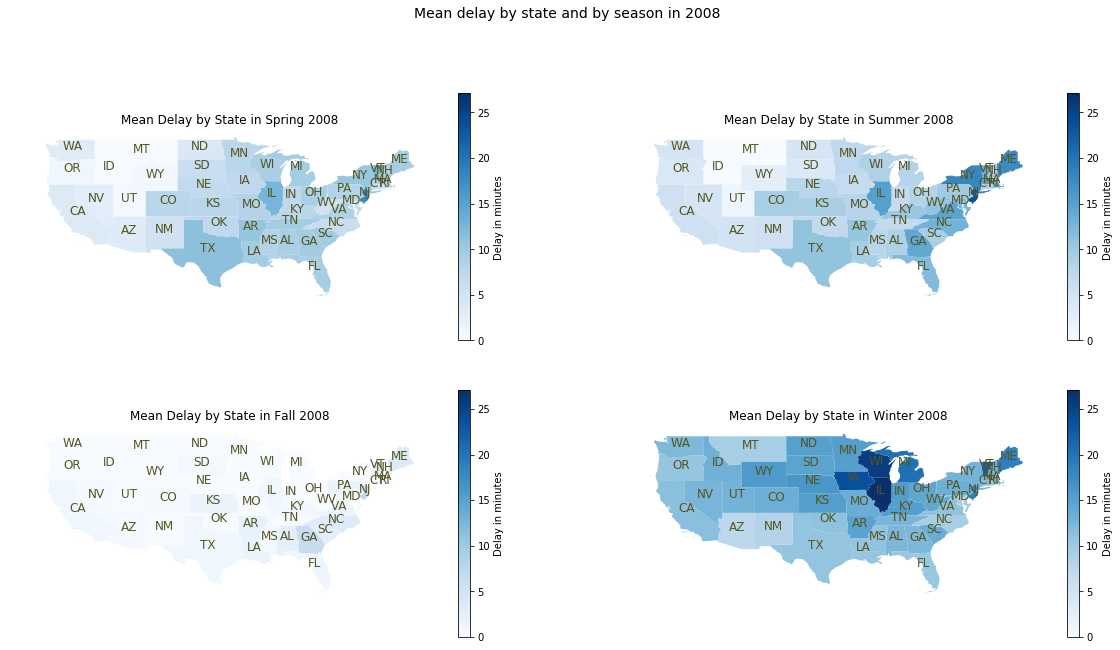

In [116]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# Zoom to US only, without Alaska and Hawai
df_non_alaska = df_map.cx[-120:-65, 20:80]

# Initiate a figure
#plt.figure(figsize = [15, 5*4])
plt.figure(figsize = [20, 10])
#f, ax = plt.subplots(2,2,figsize=(6,3));
i=0
vmax=df_non_alaska.ArrDelay.max()
for season in seasons:
    # Thanks to https://github.com/bendoesdata/make-a-map-geopandas
    ax = plt.subplot(2, 2, i+1);
    _ = ax.set_title('Mean Delay by State in ' + season + ' 2008');
    # Draw the map
    ax_map = df_non_alaska.query("Season == @season").plot(column='ArrDelay', ax=ax, cmap='Blues', legend=False,
                                                     vmin=0, vmax=vmax);
    #legend
    legend = ax_map.collections[0]
    legend = plt.colorbar(legend, ax=ax)
    legend.set_label('Delay in minutes')

    #cax = plt.gcf().axes[1]
    #cbar = plt.colorbar(ax)
    #ax_map.get_legend().set_label('Delay in minutes')
    # thanks to https://stackoverflow.com/questions/38899190/geopandas-label-polygons
    _ = df_non_alaska.query("Season == @season").apply(lambda x: ax.annotate(s=x.OriginState, xy=x.geometry.centroid.coords[0],
               fontsize=12, ha='center', color='#555520'),axis=1);
    # remove the axis
    _ = ax.axis('off');
    i+=1
plt.suptitle("Mean delay by state and by season in 2008", fontsize = 14, y = 1);

I use a vmin/vmax parameter to have a constant color for the same delay.

So we see that there is less delay everywhere in fall.

We saw that Illinois and Wisconsin are more subject to delay in Winter.

Let's have a look at mean temperature in USA states https://www.currentresults.com/Weather/US/average-state-temperatures-in-winter.php

![Mean temperature in USA](https://www.currentresults.com/Images/Maps/usa-state-temperature-winter-br.jpg "Mean temperature in USA")


It's nice to see that our delay map quite match with temperature map !

Illinois seems in the top delay state in every season.

New Jersey is more subject to delay in Summer, as the whole West coast

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Yes, plotting delay by hour of day and day of week was interresting as it show that worst time to take a plane is friday and sunday evening, probably because of people going and returning of week-end trip.

Multi-variate exploration are very useful but could be disturbing for users, so we have to be careful to polish the plot to help the users.

That's why I give a try to use map to show delay by states and seasons. It was also interresting as the winter delay map quite match with the winter temperature map !

### Were there any interesting or surprising interactions between features?

Yes, about Delay by Carrier and by City because with too many cities I choose only the top 20, so looking at data like we have only a partial view. We could take wrong conclusion from it.

Looking only at this graph I will have conclude that Pinnacle Airlines is the worst carrier in term of delay. But, in average around all cities, it's one of the best !

That demonstrate that Data Analysis is fare harder than we think. We have too look deeper in data to be sure of our conclusion. That's what we have learn in this course.

# Save Data for future use

I will save the file to CSV to use it in the slide deck notebook.

In [76]:
df.to_csv("all_flights_clean.csv")
df_late.to_csv("late_flights_only.csv")

In [77]:
# Generate the HTML version of this notebook
# jupyter nbconvert --to html Project-5-Communicate_Data_Findings.ipynb
# from subprocess import call
# call(['jupyter', 'nbconvert', '--to html', 'Project-5-Communicate_Data_Findings.ipynb'])